In [1]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, Input, Bidirectional, concatenate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

Using TensorFlow backend.


In [2]:
# you can download price data from alpha vantage

df = pd.read_csv('MSFT_daily.csv')
df = df.set_index('date')
df.index = pd.to_datetime(df.index)
target_col = 'close'

close_price = df[target_col].values.reshape(-1, 1)
open_price = df['open'].values.reshape(-1, 1)

close_price_scaller = MinMaxScaler()
close_price_scalled = close_price_scaller.fit_transform(close_price)

open_price_scaller = MinMaxScaler()
open_price_scalled = open_price_scaller.fit_transform(open_price)

print(close_price_scalled.shape)
print(open_price_scalled.shape)

(5034, 1)
(5034, 1)


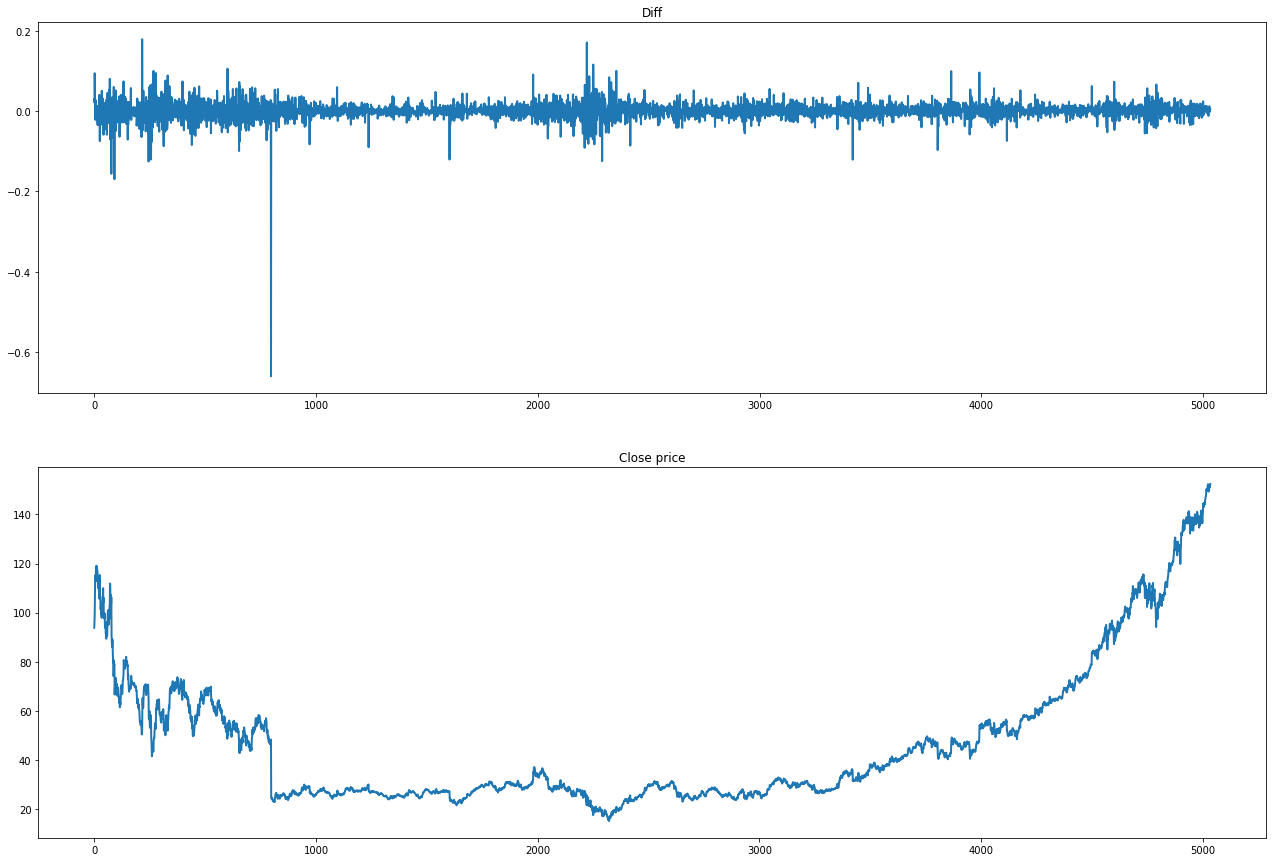

In [3]:
#watch diff log just for records, you can use it in future for classification with predictions
bc_log = pd.DataFrame(np.log(close_price))
log_diff = bc_log.diff().dropna()

fig, (ax1, ax2) = plt.subplots(2, figsize=(22, 15))
ax1.set_title('Diff')
ax1.plot(log_diff.values, linewidth=2)
ax2.set_title('Close price')
ax2.plot(close_price, linewidth=2)

In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df[:split_row]
    test_data = df[split_row:]
    return train_data, test_data

In [5]:
train_df, test_df = train_test_split(df, test_size=0.2)

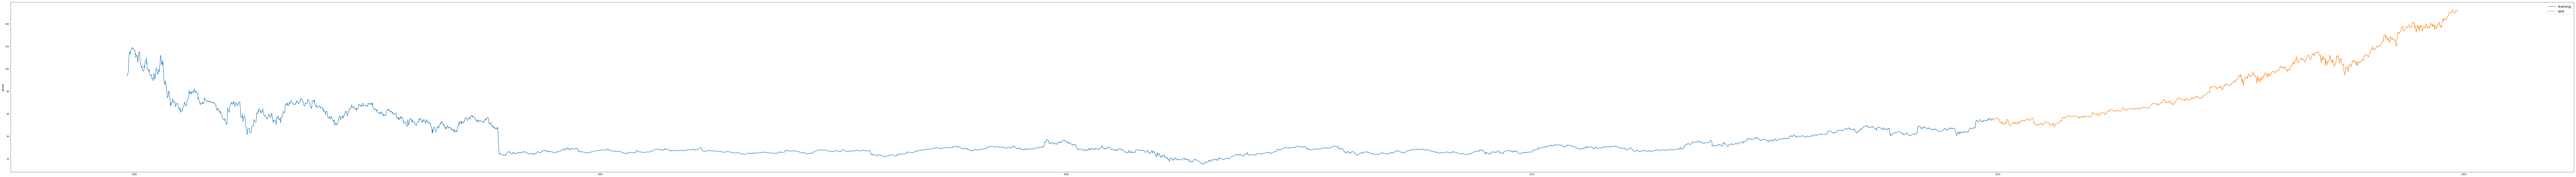

In [6]:
fig, ax = plt.subplots(1, figsize=(220, 15))
ax.plot(train_df[target_col], label='training', linewidth=2)
ax.plot(test_df[target_col], label='test', linewidth=2)
ax.set_ylabel('price', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16);

In [7]:
def accumulate_data(df, window_len):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        window_data.append(tmp)
    return np.array(window_data)

In [8]:
def calc_ema(values, time_period):
    sma = np.mean(values[:, -2])
    ema_values = [sma]
    k = 2 / (1 + time_period)
    for i in range(len(values) - time_period, len(values)):
        close = values[i][3]
        ema_values.append(close * k + ema_values[-1] * (1 - k))
    return ema_values[-1]

In [9]:
def prepare_data(df, target_col, window_len, test_size):
    scaler = MinMaxScaler()
    scaler_df = scaler.fit_transform(df)
    
    window_data_series = accumulate_data(scaler_df, window_len)
    open_data_series = np.array([open_price_scalled[index] for index in range(window_len, len(open_price_scalled))])
    close_data_series = [close_price_scalled[index] for index in range(window_len, len(close_price_scalled))]
    
    x_train, x_test = train_test_split(window_data_series, test_size)
    x_open_train, x_open_test = train_test_split(open_data_series, test_size)
    y_train, y_test = train_test_split(close_data_series, test_size)
    
    # macd
    technical_indicators = []
    for volch in accumulate_data(df, window_len):
        sma = np.mean(volch[:, -2])    
        macd = calc_ema(volch, 12) - calc_ema(volch, 26)
        
        std = np.std(volch[:, -2])
        
        upper_band = sma + (std * 2)
        lower_band = sma - (std * 2)
            
        technical_indicators.append(np.array([sma, macd, upper_band, std, lower_band]))

    technical_indicators = np.array(technical_indicators)
    tech_ind_scaler = MinMaxScaler()
    tech_ind_scaler = tech_ind_scaler.fit_transform(technical_indicators)
    tech_ind_scaler = np.array([tech_ind_scaler[index] for index in range(len(tech_ind_scaler))])
    x_tech_train, x_tech_test = train_test_split(tech_ind_scaler, test_size)
    
    return x_train, x_test, x_open_train, x_open_test, y_train, y_test, x_tech_train, x_tech_test

In [10]:
def build_lstm_model(input_data, input_indicator_data, input_open_train, output_size, 
                     neurons, dropout, loss, optimizer):
    # define three sets of inputs with differents input sizes
    lstm_input  = Input(shape=(input_data.shape[1], input_data.shape[2]), name='lstm_input')
    tech_input = Input(shape=(input_indicator_data.shape[1], ), name='tech_input')
    open_input = Input(shape=(input_open_train.shape[1], ), name='open_input')

    x = Bidirectional(LSTM(neurons, name='lstm_0'))(lstm_input)
    x = Dropout(dropout, name='lstm_dropout_0')(x)
    lstm_branch = Model(inputs=lstm_input, outputs=x)

    y = Dense(units=output_size, name='tech_dense_1')(tech_input)
    y = Activation("relu", name='tech_relu_1')(y)
    y = Dropout(dropout, name='tech_dropout_1')(y)
    technical_indicators_branch = Model(inputs=tech_input, outputs=y)
    
    z = Dense(units=output_size, name='tech_dense_2')(open_input)
    z = Activation("relu", name='tech_relu_2')(z)
    z = Dropout(dropout, name='tech_dropout_2')(z)
    open_branch = Model(inputs=open_input, outputs=z)
    
    # combine the output of the three branches
    combined = concatenate([lstm_branch.output, technical_indicators_branch.output, open_branch.output], name='concatenate')

    z = Dense(64, activation="sigmoid", name='dense_pooling')(combined)
    z = Dense(1, activation="linear", name='dense_out')(z)

    # our model will accept the inputs of the two branches and then output a single value
    model = Model(inputs=[lstm_branch.input, technical_indicators_branch.input, open_branch.input], outputs=z)
    model.compile(optimizer=optimizer, loss=loss)
    return model

In [11]:
window_len = 50
test_size = 0.2
lstm_neurons = 100
epochs = 10
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [12]:
x_train, x_test, x_open_train, x_open_test, y_train, y_test, x_tech_train, x_tech_test = prepare_data(df.values, target_col, window_len, test_size)

print(x_train.shape)
print(x_test.shape)
print(x_open_train.shape)
print(x_open_test.shape)
print(x_tech_train.shape)
print(x_tech_test.shape)

(3988, 50, 5)
(996, 50, 5)
(3988, 1)
(996, 1)
(3988, 5)
(996, 5)


In [13]:
y_train = np.array(y_train).reshape(1, -1).squeeze()
y_test = np.array(y_test).reshape(1, -1).squeeze()

print(y_train.shape)
print(y_test.shape)

(3988,)
(996,)


In [14]:
model = build_lstm_model(x_train, x_tech_train, x_open_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(x=[x_train, x_tech_train, x_open_train], y=y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.05)

Train on 3788 samples, validate on 200 samples
Epoch 1/10
3788/3788 [==============================] - 26s 7ms/step - loss: 0.0145 - val_loss: 6.3099e-04
Epoch 2/10
3788/3788 [==============================] - 23s 6ms/step - loss: 4.3845e-04 - val_loss: 1.8132e-04
Epoch 3/10
3788/3788 [==============================] - 23s 6ms/step - loss: 3.4634e-04 - val_loss: 1.5705e-04
Epoch 4/10
3788/3788 [==============================] - 27s 7ms/step - loss: 2.8954e-04 - val_loss: 1.1994e-04
Epoch 5/10
3788/3788 [==============================] - 29s 8ms/step - loss: 2.4499e-04 - val_loss: 1.1416e-04
Epoch 6/10
3788/3788 [==============================] - 37s 10ms/step - loss: 2.2312e-04 - val_loss: 1.0454e-04
Epoch 7/10
3788/3788 [==============================] - 26s 7ms/step - loss: 1.9670e-04 - val_loss: 1.3416e-04
Epoch 8/10
3788/3788 [==============================] - 25s 7ms/step - loss: 1.9615e-04 - val_loss: 1.2558e-04
Epoch 9/10
3788/3788 [==============================] - 28s 7ms/step

In [15]:
preds = model.predict([x_test, x_tech_test, x_open_test]).squeeze()
mean_absolute_error(preds, y_test)

0.011188932196784048

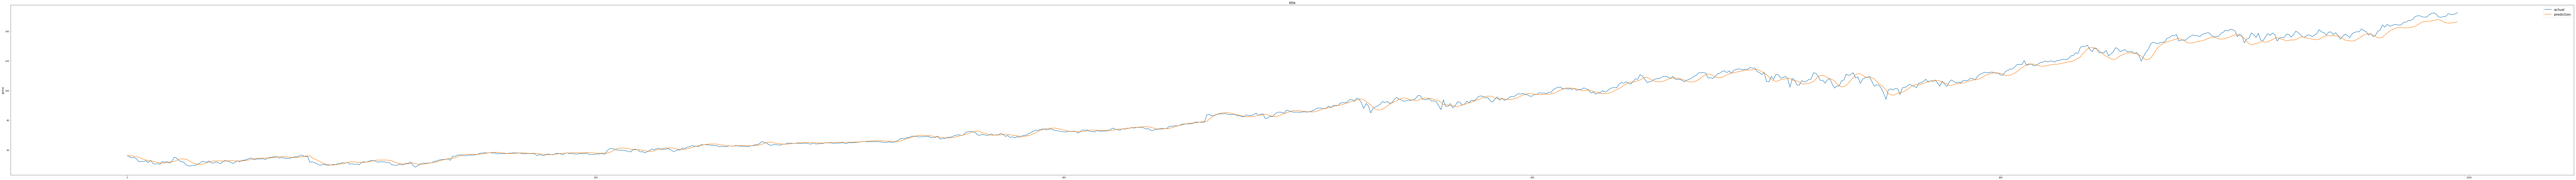

In [16]:
open_real_normallized = close_price_scaller.inverse_transform(x_open_test.reshape(-1, 1))
close_real_normallized = close_price_scaller.inverse_transform(y_test.reshape(-1, 1))
close_pred_normallized = close_price_scaller.inverse_transform(preds.reshape(-1, 1))

fig, ax = plt.subplots(1, figsize=(220, 15))
ax.plot(close_real_normallized, label='actual', linewidth=2)
ax.plot(close_pred_normallized, label='prediction', linewidth=2)
ax.set_ylabel('price', fontsize=14)
ax.set_title('title', fontsize=16)
ax.legend(loc='best', fontsize=16);

In [17]:
def calculate_profit():
    balance = 100
    balance_story = []

    for i, (open_price, close_price, pred) in enumerate(zip(open_real_normallized, close_real_normallized, pred_bi_direct)):
        if i == 0:
            continue
        total_delta = close_price - open_price
        price_range = int(np.round(total_delta.squeeze(), 2) * 100)

        if pred > 0 and price_range > 0:
            balance = balance + price_range
            balance_story.append(balance)
        elif pred > 0 and price_range <= 0:
            balance = balance - abs(price_range)
            balance_story.append(balance)

        if pred < 0 and price_range < 0:
            balance = balance + abs(price_range)
            balance_story.append(balance)
        elif pred < 0 and price_range >= 0:
            balance = balance - abs(price_range)
            balance_story.append(balance)

    return balance_story

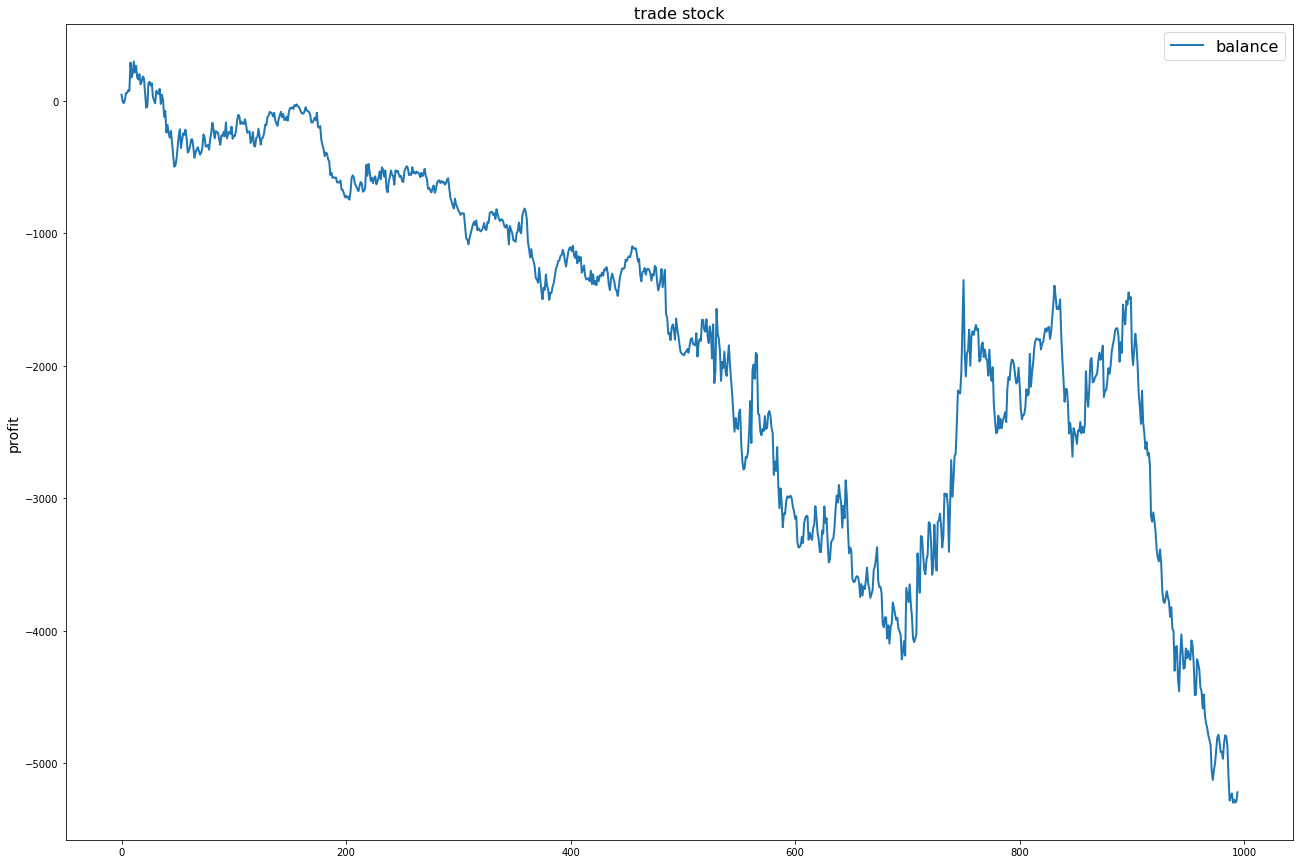

In [18]:
pred_bi_direct =[0]
for index in range(1, len(close_pred_normallized)):
    prev_pred = close_pred_normallized[index-1]
    pred = close_pred_normallized[index]
    delta_pred = prev_pred - pred
    pred_bi_direct.append(1 if delta_pred < 0 else -1)

balance_story = calculate_profit()

fig, ax = plt.subplots(1, figsize=(22, 15))
ax.plot(balance_story, label='balance', linewidth=2)
ax.set_ylabel('profit', fontsize=14)
ax.set_title('trade stock', fontsize=16)
ax.legend(loc='best', fontsize=16)

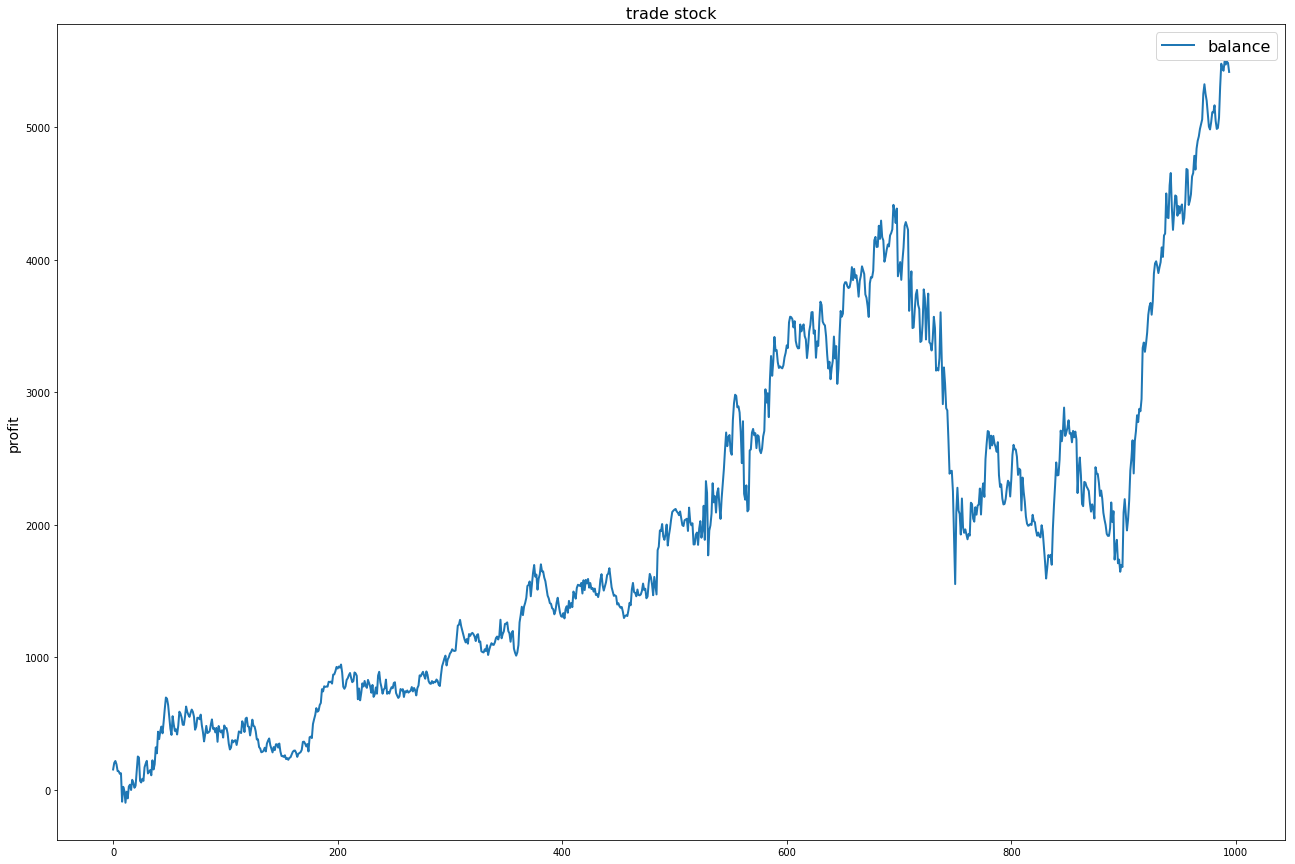

In [19]:
pred_bi_direct =[0]
for index in range(1, len(close_pred_normallized)):
    prev_pred = close_pred_normallized[index-1]
    pred = close_pred_normallized[index]
    delta_pred = prev_pred - pred
    pred_bi_direct.append(-1 if delta_pred < 0 else 1)

balance_story = calculate_profit()

fig, ax = plt.subplots(1, figsize=(22, 15))
ax.plot(balance_story, label='balance', linewidth=2)
ax.set_ylabel('profit', fontsize=14)
ax.set_title('trade stock', fontsize=16)
ax.legend(loc='best', fontsize=16)